In [3]:
import sys
moseq_path = '/media/data_cifs/matt/moseq2-viz'
sys.path.append(moseq_path)

In [4]:
import numpy as np
import csv
import networkx as nx
import nltk
from nltk.util import ngrams
import matplotlib.pyplot as plt
from itertools import combinations, combinations_with_replacement
import torch
from torch.utils.data import DataLoader
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity
import sys
moseq_path = '/media/data_cifs/matt/moseq2-viz'
sys.path.append(moseq_path)
import moseq2_viz
from moseq2_viz.util import parse_index
from moseq2_viz.model.util import (get_transition_matrix,
                                   parse_model_results,
                                   results_to_dataframe,
                                   relabel_by_usage, get_syllable_statistics)
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Phrases
import gensim.models.phrases
import operator
from collections import Counter
from tqdm.notebook import tqdm
import seaborn as sns
import pdb
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='4'

def partition(collection):
    if len(collection) == 1:
        yield [ collection ]
        return

    first = collection[0]
    for smaller in partition(collection[1:]):
        # insert `first` in each of the subpartition's subsets
        for n, subset in enumerate(smaller):
            yield smaller[:n] + [[ first ] + subset]  + smaller[n+1:]
        # put `first` in its own subset 
        yield [ [ first ] ] + smaller
        

In [65]:
class FreePhrases(object):
    def __init__(self, corpus,n, min_count=1, threshold=.01, vocab=None, replacement=False):
        self.n = n
        self.free_ngrams = []
        # Replacement should be _false_ for emission data. 
        if type(corpus[0]) is not 'list':
            for m in range(1,n+1):
                self.free_ngrams.append(self.get_free_ngrams(corpus,m,vocab=vocab,replacement=replacement))
        elif type(corpus[0] is 'list'):
            for m in range(1,n+1):
                free_mgrams = {}
                for doc in corpus:
                    doc_free_mgrams = self.get_free_ngrams(corpus,m,vocab=vocab,replacement=replacement)
                    free_mgrams = Counter(free_mgrams) + Counter(doc_free_mgrams)
                self.free_ngrams.append(free_mgrams)
        else:
            raise ValueError('Corpus be a list of strings or list of lists of strings.')
        self.free_ngrams[0] = {onegram : (count,0) for (onegram,count) in self.free_ngrams[0].items()}
        for m in range(1,n):
            free_mgrams = self.free_ngrams[m]
            pdb.set_trace()
            for (mgram, count) in free_mgrams.items():
                P = [ p for p in partition(list(mgram))]
                l_mgram = [s for s in mgram]
                subcounts = [self.free_ngrams[len(pp) - 1][tuple(pp)][0] for qq in P for pp in qq if pp != l_mgram]
                score = (count - min_count) / np.prod(subcounts)
                self.free_ngrams[m][mgram] = (count,score)
        
    def get_free_ngrams(self, list_of_strings,n,vocab=None, replacement=False):
        comb = combinations if replacement is False else combinations_with_replacement
        free_ngrams = {}
        if vocab is not None:
            free_ngrams = {comb : 0 for comb in combinations_with_replacement(vocab,n)}
            for i in range(len(list_of_strings) - (n-1)):
                subseq = list_of_strings[i:i+n]
                sorted_subseq = np.sort([int(syl) for syl in subseq])
                key = tuple([str(p) for p in sorted_subseq])
                free_ngrams[key] += 1
        return free_ngrams 
#     def rewrite_sentence(self,sentence, sep='_'):
#         for ngram

In [66]:
corpus = [str(p) for p in np.random.randint(100,size=1000)]
vocab = [str(q) for q in range(0,100)]
n  = 3
FP = FreePhrases(corpus,n,vocab=vocab)

ngram_dicts = FP.free_ngrams
bigrams = ngram_dicts[2]
for (tg, val) in bigrams.items():
    count = val[0]
    score = val[1]
    
    print('{} : Count {}. Score {}.'.format(tg, count,score))

> <ipython-input-65-43e8a36e8f04>(22)__init__()
-> for (mgram, count) in free_mgrams.items():
(Pdb) c
> <ipython-input-65-43e8a36e8f04>(21)__init__()
-> pdb.set_trace()
(Pdb) n
> <ipython-input-65-43e8a36e8f04>(22)__init__()
-> for (mgram, count) in free_mgrams.items():
(Pdb) n
> <ipython-input-65-43e8a36e8f04>(23)__init__()
-> P = [ p for p in partition(list(mgram))]
(Pdb) n
> <ipython-input-65-43e8a36e8f04>(24)__init__()
-> l_mgram = [s for s in mgram]
(Pdb) P
[[['0', '0', '0']], [['0'], ['0', '0']], [['0', '0'], ['0']], [['0'], ['0', '0']], [['0'], ['0'], ['0']]]
(Pdb) n
> <ipython-input-65-43e8a36e8f04>(25)__init__()
-> subcounts = [self.free_ngrams[len(pp) - 1][tuple(pp)][0] for qq in P for pp in qq if pp != l_mgram]
(Pdb) n
> <ipython-input-65-43e8a36e8f04>(26)__init__()
-> score = (count - min_count) / np.prod(subcounts)
(Pdb) subcounts
[12, 0, 0, 12, 12, 0, 12, 12, 12]
(Pdb) exit


BdbQuit: 

# Load and process data

In [7]:
# Note: custom_labels are for custom groupings of data (currently only implemented for SCI data)

super_dir = '/media/data_cifs/matt/abraira_data' # Where all your data is stored
experiment = '2021-02-19_Meloxicam' # Sub-folder name
use_custom_labels = True
max_syllable = 70
num_transitions = 500 #max_syllable

if experiment == '2021-02-19_Meloxicam':
    model_file = os.path.join(super_dir, experiment, 'rST_model_1000.p')
    index_file = os.path.join(super_dir, experiment, 'moseq2-index.role.yaml')
    groups = ['baseline', '4hrs carrageenan', '24hrs saline', '24hrs meloxicam', 'baseline meloxicam']
    if not use_custom_labels:
        custom_labels = []
        custom_label_names = groups
    else:
        custom_labels = [0,1,2,3,4]
        custom_label_names = groups
        
elif experiment == 'WWC1_W88C':
    model_file = os.path.join(super_dir, experiment, 'robust_septrans_model_500.p')
    index_file = os.path.join(super_dir, experiment, 'moseq2-index.sex-genotype.yaml')
    groups = ['M_WC/WC', 'F_WC/WC', 'M_+/WC', 'F_+/WC', 'M_+/+', 'F_+/+']
    ## I AM LEAVIG OUT M_ukn!
    if not use_custom_labels:
        custom_labels = []
        custom_label_names = groups
    else:
        custom_labels = [0, 0, 1, 1, 2, 2]
        custom_label_names = ['WC/WC', '+/WC', '+/+']
        
elif experiment == '2019-07-12_Junbing_Bicuculline_Celsr3-PvCre':
    model_file = os.path.join(super_dir, experiment, 'first_model.p')
    index_file = os.path.join(super_dir, experiment, 'moseq2-index-cohort-sex-role.yaml')
    groups = ['default', 'Bicuculline_Control_UKN', 'Bicuculline_Experimental_UKN',
              'ctrl_wt_control_Male', 'ctrl_wt_control_Female',
              'Celsr3_PvCre_Control_Male', 'Celsr3_PvCre_Control_Female',
              'Celsr3_PvCre_Experimental_Male', 'Celsr3_PvCre_Experimental_Female',
              'Celsr3_PvCre_Het_Female','Celsr3_PvCre_Het_Male']
    
    if not use_custom_labels:
        custom_labels = []
        custom_label_names = groups
    else:
        custom_labels = [0,1,2,3,3,4,4,5,5,6,6]
        custom_label_names = ['Default', 'Bicuculline_Control', 'Bicuculline_Experimental',
                             'Ctrl_WT', 'Celsr3_ctrl', 'Celsr3_Exp', 'Celsr3_Het']
    BMS_Left = []
    BMS_Right = []
    with open(os.path.join(super_dir, experiment, "session_manifest.tsv")) as fd:
        rd = csv.reader(fd, delimiter="\t", quotechar='"')
        for r, row in enumerate(rd):
            if r == 0 or (len(row) < 17): continue
            BMS_Left.append(int(row[-3]))
            BMS_Right.append(int(row[-2]))
        
elif experiment == '2020-11-10_Celsr3-R774H':
    model_file = os.path.join(super_dir, experiment, 'robust_septrans_model_1000.p')
    index_file = os.path.join(super_dir, experiment, 'gender-genotype-index.yaml')
    groups = ['F_+/+', 'F_RH/RH', 'F_+/RH', 'M_+/+', 'M_RH/RH', 'M_+/RH']
    if not use_custom_labels:
        custom_labels = []
        custom_label_names = groups
    else:
        custom_labels = [0,1,2,0,1,2]
        custom_label_names = ['+/+','RH/RH','+/RH']
        
elif experiment == 'SstCre_Celsr3CKO':
    model_file = os.path.join(super_dir, experiment, 'robust_septrans_model_20min_1000.p')
    index_file = os.path.join(super_dir, experiment, 'moseq2-index.sex-genotype.20min.yaml')
    groups = ['F_+/+;Celsr3^f/f', 'F_Sst-Cre/+;Celsr3^f/f', 'M_Sst-Cre/+;Celsr3^f/f', 'M_+/+;Celsr3^f/f']
    if not use_custom_labels:
        custom_labels = []
        custom_label_names = groups
    else:
        custom_labels = [0,1,1,0]
        custom_label_names = ['Sst-Cre', '+/+']
        
elif experiment == '2019SCI':
    model_file = os.path.join(super_dir, experiment, 'second_model.p')
    index_file = os.path.join(super_dir, experiment, 'moseq2-index.timepoint.yaml')
    groups = ['before SCI'] + ['{} week after SCI'.format(w) for w in range(2,8)]
    if not use_custom_labels:
        custom_labels = []
        custom_label_names = groups
    else:
        custom_labels = [0,1,1,1,2,2,2]
        custom_label_names = ['Pre-Injury', '2-4 weeks', '5-7 weeks']
    BMS_Left = []
    BMS_Right = []
    with open(os.path.join(super_dir, experiment, "cohort_manifest.tsv")) as fd:
        rd = csv.reader(fd, delimiter="\t", quotechar='"')
        for r, row in enumerate(rd):
            if r == 0 or (len(row) < 17): continue
            BMS_Left.append(int(row[-3]))
            BMS_Right.append(int(row[-2]))
            
elif experiment == '2021-06-04_P4_C2_SCI_timecourse':
    timepoint = '10'
    model_file = os.path.join(super_dir, experiment, 'P{}-sex_rST_model_1000.p'.format(timepoint)) 
    index_file = os.path.join(super_dir, experiment, 'moseq2-index.P{}.grouped-sex.yaml'.format(timepoint))
    
    groups = ['P4_C2_SCI_P{}_M', 'P4_C2_SCI_P{}_F','Control_P{}_M','Control_P{}_F']
    custom_labels = [0,0,1,1]
    custom_label_names = ['Injury', 'Control']
    for g in range(len(groups)):
        groups[g] = groups[g].format(timepoint)
    if timepoint == '10':
        groups.remove( 'P4_C2_SCI_P10_F')
        del custom_labels[1]
    elif timepoint == '60' or timepoint=='90':
        groups.remove('Control_P{}_F'.format(timepoint))
        del custom_labels[-1]

palette = sns.color_palette(['#f06493', '#35fab3', '#647aa3', '#020887', '#ff0000'])


In [14]:
# Process data
# Data to store
_, sorted_index = parse_index(index_file)
ms_model = parse_model_results(model_file, sort_labels_by_usage=True, count='usage')
labels = ms_model['labels']
label_group = [sorted_index['files'][uuid]['group'] for uuid in ms_model['keys']]

use_BMS_custom_labels = False
bms_custom_labels = [0,0,0,1,1,1,2,2,2]
tm_vals = []
truncated_tm_vals = []
group_vals = []
group_labels = []
usage_vals = []
frames_vals = []
sentences = []
bigram_sentences = []
sentence_strings = []
sentence_groups = {group : [] for group in groups}
bad_syllables = [-5] # <---- Syllables to omit
for i, (l, g) in tqdm(enumerate(zip(labels, label_group))):
    
    if g not in groups and g != 'M_ukn':
        raise ValueError('Group name in data not recognized. Check the group names you specified!')
    elif g == 'M_ukn':
        continue
    group_vals.append(g)

    # Label data using default or custom labels
    if not use_custom_labels and not use_BMS_custom_labels:
        group_labels.append(groups.index(g))
    elif not use_BMS_custom_labels:
        group_labels.append(custom_labels[groups.index(g)])
    else:
        group_labels.append(bms_custom_labels[BMS_Right[i] - 1])

    # Get transitions
    tm = get_transition_matrix([l], combine=True, max_syllable=max_syllable - 1)
    tm_vals.append(tm.ravel())

    # Get usages
    u, _ = get_syllable_statistics(l, count='usage')
    u_vals = list(u.values())[:max_syllable]
    total_u = np.sum(u_vals)
    usage_vals.append(np.array(u_vals) / total_u)

    # Get frame values
    f, _ = get_syllable_statistics(l, count='usage')
    total_f = np.sum(list(f.values()))
    frames_vals.append(np.array(list(f.values())) / total_f)

    # Get emissions
    l = list(filter(lambda a: a not in bad_syllables, l))
    np_l = np.array(l)
#     cp_inds = np.concatenate((np.where(np.diff(np_l) != 0 )[0],np.array([len(l) - 1])))
#     syllables = np_l[cp_inds]
    syllables = np_l
    sentence = [str(syl) for syl in syllables]
    sentences.append(sentence)
    sentence_strings.append(' '.join(sentence))
    sentence_groups[g].append(sentence)

    bigram_model = Phrases(sentence, min_count=1, threshold=1, scoring='default')
    bgs = bigram_model[sentence]
#     print(len([phr for phr in bgs if '_' in phr]))
    bigram_sentences.append(bgs)
        
# Post-processing including truncation of transitions
# Truncated transitions
tm_vals = np.array(tm_vals)
top_transitions = np.argsort(tm_vals.mean(0))[-num_transitions:]
truncated_tm_vals = tm_vals[:,top_transitions]

# Make numpy
usage_vals = np.array(usage_vals)
frames_vals = np.array(frames_vals)
num_animals = len(sentences)

np_g = np.array(group_labels)
group_sizes = [sum(np_g == g) for g in np.unique(np_g)]
lb_ind = np.argsort(np_g)

In [15]:
len(sentences[0])

35949

# Train model

In [16]:
# Turn emissions per animal ("sentences") into TaggedDocument obejcts
use_bigrams = False
which_sentences = bigram_sentences if use_bigrams else sentences
documents = [TaggedDocument(sent, [i]) for i, sent in enumerate(which_sentences)]

In [17]:
dim = 300 #max_syllable # Dimension of embedding space
window = 20 # Window size for context (this is left and right, so total size is 2*window)

# Initialize and train two models on the documents. Embeddings will be averaged, which is standard. 
# Note: min_count = <min_count> omits words with usages less than <min_count>
print('Training dm=1')
model1 = Doc2Vec(documents, dm=1, epochs=50, vector_size=dim, window=window, min_count=1, workers=1)
print('Training dm=0')
model2 = Doc2Vec(documents, dm=0, epochs=50, vector_size=dim, window=window, min_count=1, workers=1)
print('Done')

Training dm=1
Training dm=0
Done


In [18]:
# Infer embeddings per document per model and then average. 
which_sentences = bigram_sentences if use_bigrams else sentences

E1 = [model1.infer_vector(sent) for sent in which_sentences]
E2 = [model2.infer_vector(sent) for sent in which_sentences]
E = [.5 * (em1 + em2) for (em1, em2) in zip(E1, E2)]

[ 0 11 20]


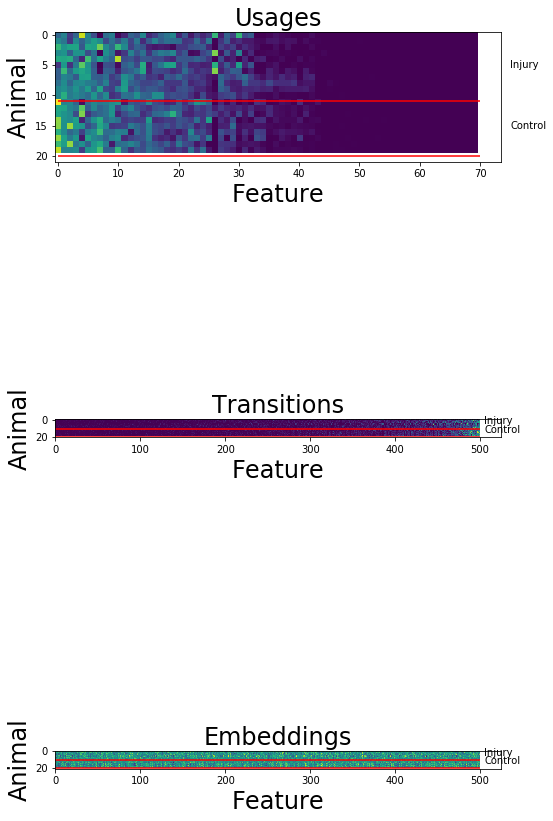

In [87]:
# Plot all three representation types: usages, transitions, embeddings

fig, axes = plt.subplots(3,1, figsize = (8,16))
line_heights = np.concatenate((np.array([0]), np.cumsum(group_sizes)))
print(line_heights)
for ax, ti, rep in zip(axes, ['Usages', 'Transitions','Embeddings'],[usage_vals, truncated_tm_vals, E]):
    np_rep = np.array(rep)
    ax.imshow(np_rep[lb_ind,:])
    ax.set_title(ti, fontsize=24)
    ax.set_xlabel('Feature', fontsize=24)
    ax.set_ylabel('Animal', fontsize=24)
    ax.hlines(line_heights[1:], 0, np_rep.shape[-1], colors='r')
    for s, sl in enumerate(custom_label_names):
        ax.text(float(np_rep.shape[-1] + 5), .5*(line_heights[s] + line_heights[s+1]), sl)
plt.subplots_adjust(hspace=.6)
plt.show()
plt.close()

# Train classifier with K-fold cross-validation (K=1 for leave-one-out)

In [ ]:
from sklearn.linear_model import LogisticRegression
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
from IPython.core.debugger import Tracer

seed=0
K = 1 # K-fold cross-validation
C = 1e-3 #9e-1 # C is inversely proporitional to L2 regularization
all_C = np.logspace(-6,6, num=13)
penalty = 'l2'
# all_C = [1e5]

# Permute training data
perm_ind = np.random.permutation(num_animals)
perm_embeddings = np.array(E)[perm_ind,:]
perm_usages = usage_vals[perm_ind,:]
perm_trans  = truncated_tm_vals[perm_ind,:]
perm_labels = np.array(group_labels)[perm_ind]
# perm_labels = np.array(BMS_Right)[perm_ind]

accs_per_C = []
accs_per_rep = []
names = ['Usages', 'Transitions', 'Embeddings']
# For each representation
seed=0
for C in tqdm(all_C):
    accs = [[],[],[]]
    for j, (nm, rep) in enumerate(zip(names,[perm_usages, perm_trans, perm_embeddings])):
        # For each split
        for i in range(int(num_animals / float(K))):
#             print(i)
            # New split of data and labels
            shifted_rep = np.roll(rep, i*K, axis=0)
            shifted_labels = np.roll(perm_labels, i*K, axis=0)

            # Split into train and test
            train_X, train_y = shifted_rep[K:,:], shifted_labels[K:]
            test_X, test_y = shifted_rep[:K,:], shifted_labels[:K]

            # Load and train classifier
            if penalty is not 'none':
                clf = LogisticRegression(random_state=seed,dual=False,solver='lbfgs', penalty=penalty,class_weight='balanced',
                                     multi_class='auto',C=C, tol=1e-6, max_iter=2000).fit(train_X, train_y)
            else:
                clf = LogisticRegression(random_state=seed,dual=False,solver='lbfgs',class_weight='balanced',
                         multi_class='auto', tol=1e-5, max_iter=2000).fit(train_X, train_y)
            # Predict on held-out data
            y_pred = clf.predict(test_X)
            # Store average accuracy on test set for this split for this representation
            accs[j].append(np.mean(1*(y_pred == test_y)))
    accs_per_C.append(np.array(accs).mean(-1))
#         accs_per_rep.append(np.mean(accs[j]))
#         print('Testing accuracy for {}: {}'.format(nm, np.mean(accs[j])))
# print(accs_per_C)

0.7125 10000.0
0.7875 100000.0
0.8625 100000.0


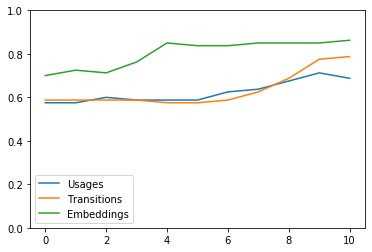

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05]


In [20]:
# plt.bar(np.arange(3),accs_per_rep)
# plt.show()
# plt.close()
# print(accs_per_C)
tmp = np.array(accs_per_C)
for res in tmp.T:
    print(np.max(res), all_C[np.argmax(res)])

plt.plot(accs_per_C)
plt.ylim([0,1.0])
plt.legend(['Usages', 'Transitions', 'Embeddings'])
plt.show()
plt.close()
print(all_C)
 

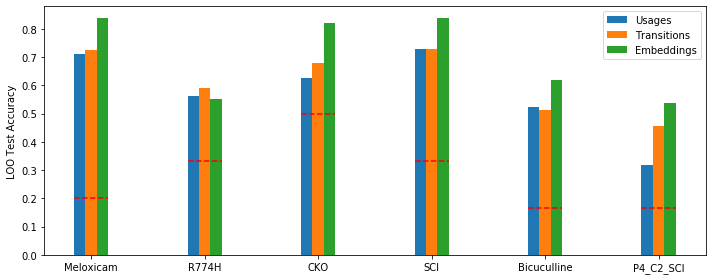

In [29]:
# Notes: 
#  Experiment | # Classes | Best Accuracies, (Associated penalties)|
# Meloxicam   |  5        | 0.62, 0.59, 0.78 (1e4, 1e4, 1e4)
# R774H       |  3        | 0.45, 0.40, 0.51 (1e4, 1e4, 1e4)
# CKO         |  2        | 0.62, 0.61, 0.74 (1e4, 1e-4, 1e4)
# SCI         |  3        | 0.75, 0.75, 0.84 (1e4, 1e4, 1e-4)

# results = np.array([[0.62, 0.59, 0.78],[0.45, 0.40, 0.51],[0.62, 0.61, 0.74],[0.75, 0.75, 0.84]])
Us = [.7125, .5612, .625, .7297, .5220, .3200]
Tr = [.725, .5918, .6786, .7297, .5115, .456]
Em = [.8375, .5510, .8214, .8378, .6188, .536]

classes = [5,3,2,3, 6, 6]

labels = ['Meloxicam', 'R774H', 'CKO', 'SCI', 'Bicuculline', 'P4_C2_SCI']

x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars,

fig, ax = plt.subplots(figsize=(10,4))
rects1 = ax.bar(x - width, Us, width, label='Usages')
rects2 = ax.bar(x, Tr, width, label='Transitions')
rects3 = ax.bar(x + width, Em, width, label='Embeddings')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('LOO Test Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for i, n in enumerate(classes):
    chance = 1. / n
    ax.hlines(chance, x[i] - 1.5*width, x[i] + 1.5*width, colors='r', linestyles='dashed')

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()
plt.close()

## Summarization 1: n-gram statistics

Summarzing animals by scoring n-grams by relative frequency. See https://arxiv.org/abs/1310.4546

In [15]:
from gensim.models.phrases import Phrases

# How many total phrases to keep track of per n-gram model
num_phrases = 10

# Let's just look at 2-3-4-grams 
all_bigram_models = []
all_bigram_sentences = []
all_trigram_models = []

# For each experimental group
which_labels = custom_label_names if use_custom_labels else groups

for l, label in enumerate(which_labels):
    print(label)
    
    # Get emissions for this group
    if not use_custom_labels:
        group_sentences = sentence_groups[label]
    else:
        group_sentences = []
        custom_groups = [groups[i] for i,j in enumerate(custom_labels) if j == l]
        for cgroup in custom_groups:
            group_sentences += sentence_groups[cgroup]
    
    # Bigrams: Omit emissions with fewer than min_count occurences. Threshold=.01 essentially means that all grams will be scored and returned
    bigram_model = Phrases(group_sentences, min_count=10, threshold=.01)
    bigram_sentences = [sent for sent in bigram_model[group_sentences]] # New emissions with bi-grams condensed to single tokens
    all_bigram_models.append(bigram_model) # store bigram model for this animal.
    
    # Do same thing, but now on the bigram sentences. This gives 3 and 4 grams (compositions of 1,2-grams)
    trigram_model = Phrases(bigram_sentences, min_count=10, threshold=.01)
    all_trigram_models.append(trigram_model)
    
    # Now print results
    for which_sentences, model in zip([group_sentences, bigram_sentences],[bigram_model, trigram_model]):
        scores  = np.array([score  for (phrase, score) in model.find_phrases(which_sentences).items()])
        phrases = [phrase for (phrase, score) in model.find_phrases(which_sentences).items()]
        median_score = np.median(scores)

        total_score = sum(scores)
        score_inds = np.argsort(scores)[::-1]
        sorted_scores  = scores[score_inds]
        sorted_phrases = [phrases[i] for i in score_inds]
                
        top_scores = sorted_scores[:num_phrases]
        top_phrases = sorted_phrases[:num_phrases]

        print('Top phrases n-gram/1-gram ratios')
        
        for phr, sc in zip(top_phrases, top_scores):
            print('{}  : {}'.format(phr,sc))
        print('\n')

Pre-Injury
Top phrases n-gram/1-gram ratios
8_49  : 1.738821307559851
54_68  : 1.3474979491386383
68_66  : 1.232107451231212
65_64  : 1.1737651418773163
15_10  : 1.1215649743828597
54_65  : 1.0496720913286375
49_8  : 0.9697272676776093
68_64  : 0.8996824210722959
69_52  : 0.8889217025360847
5_35  : 0.806461780929866


Top phrases n-gram/1-gram ratios
69_16_69  : 11.372222222222222
54_65_64_6  : 7.5841566690190545
54_68_64_6  : 6.396875
54_68_66_6  : 5.904807692307693
54_68_66_57  : 2.9242857142857144
6_23_21_23  : 1.9925373134328357
47_54_65_64  : 1.8541666666666665
21_23_21_23  : 1.026008019603475
6_23_6_16  : 0.37605633802816896


2-4 weeks
Top phrases n-gram/1-gram ratios
48_32  : 1.1256646216768915
6_16  : 1.025039183455025
12_38  : 0.9116947245253865
51_27  : 0.8737984218077475
31_49  : 0.8587788724410353
50_24  : 0.8186988089702779
11_63  : 0.8064374985083651
39_59  : 0.7893582660433489
6_12  : 0.7671179316748937
24_50  : 0.7641188883722594


Top phrases n-gram/1-gram ratios
34_1

## Summarization 2: Now let's track common motifs over recovery time

So far, I just measure the scores of relevant pre-injury motifs over recovery. But maybe there is a better way to measure progress. Also, this depends strongly on the min-count parameter above.

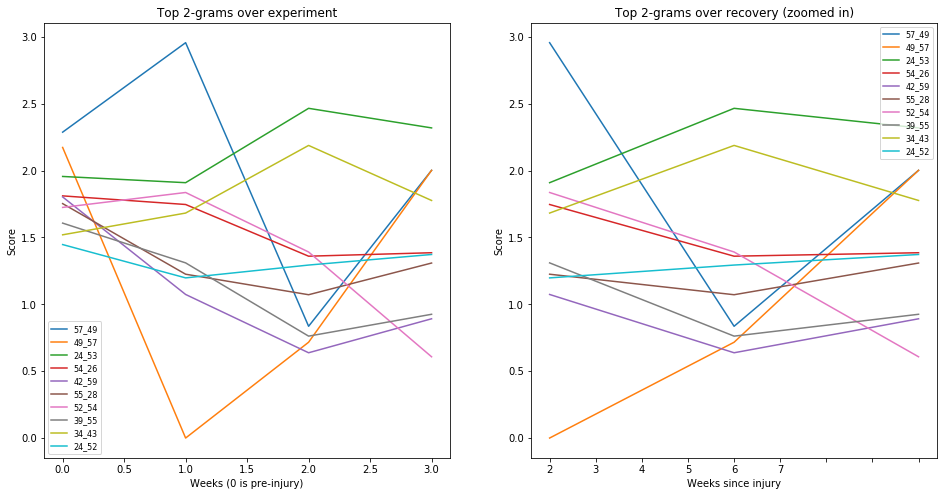

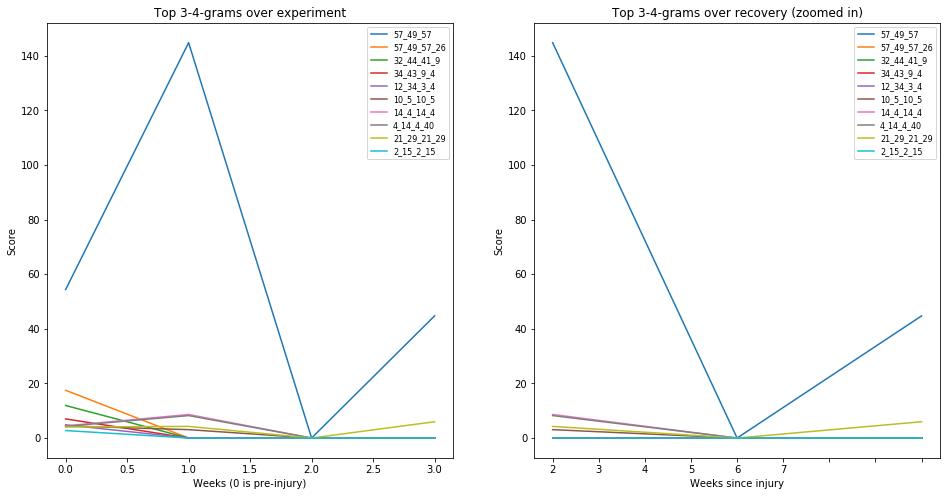

In [77]:
for m, (nm, all_ngram_models) in enumerate(zip(['2-grams', '3-4-grams'],[all_bigram_models, all_trigram_models])):
    
    # Choose correct pre-injury sequences
    if m == 0:
        pre_injury_sentences = sentence_groups[groups[0]]
    else:
        pre_injury_sentences = sentence_groups[groups[0]]
        pre_injury_sentences = [sent for sent in all_bigram_models[0][pre_injury_sentences]]

    # Get pre-injury scores and phrases
    pre_injury_scores = np.array([score  for (phrase, score) in all_ngram_models[0].find_phrases(pre_injury_sentences).items()])
    pre_injury_phrases = [phrase for (phrase, score) in all_ngram_models[0].find_phrases(pre_injury_sentences).items()]
    
    score_inds = np.argsort(pre_injury_scores)[::-1]
    sorted_scores  = pre_injury_scores[score_inds]
    sorted_phrases = [pre_injury_phrases[i] for i in score_inds]
    top_scores = sorted_scores[:num_phrases]
    top_phrases = sorted_phrases[:num_phrases]

    # Store scores of frequent pre-injury motifs in this matrix
    recovery_mx = np.zeros((len(groups), num_phrases))
    recovery_mx[0,:] = top_scores

    # For each post-recovery week, re-calculate score in n-gram model
    for g in range(1, len(groups)):
        if m == 0:
            group_sentences = sentence_groups[groups[g]]
        else:
            group_sentences = sentence_groups[groups[g]]
            group_sentences = [sent for sent in all_bigram_models[g][group_sentences]]
            
        model = all_ngram_models[g]
        model_dict = model.find_phrases(group_sentences)

        # Store scores of pre-injury motifs in the current week's model
        injury_scores = []
        for phr in top_phrases:
            if phr in model_dict.keys():
                injury_scores.append(model_dict[phr])
            else:
                injury_scores.append(0.0)
        recovery_mx[g,:] = np.array(injury_scores)

    fig, axes = plt.subplots(1,2,figsize=(16,8))
    axes[0].plot(recovery_mx)
    axes[0].legend([phr for phr in top_phrases], fontsize=8)
    axes[0].set_ylabel('Score')
    axes[0].set_xlabel('Weeks (0 is pre-injury)')
    axes[0].set_title('Top {} over experiment'.format(nm))

    axes[1].plot(recovery_mx[1:,:])
    axes[1].legend([phr for phr in top_phrases], fontsize=8)
    axes[1].set_xticklabels([1,2,3,4,5,6,7])
    axes[1].set_ylabel('Score')
    axes[1].set_xlabel('Weeks since injury')
    axes[1].set_title('Top {} over recovery (zoomed in)'.format(nm))

    plt.show()
    plt.close()


# Summarization 3: TextRank

Let's make a graph whose nodes are all n-grams in an injury group and whose edges are the semantic similarity of the n-grams in the embedding space.

In [78]:
from nltk.util import ngrams

# which n
n = 2
ng_groups = []

# For each experimental group
for g, group in enumerate(groups):
    
    current_sentences = sentence_groups[group]
    flat_sentences = [item for sublist in current_sentences for item in sublist] # Technically this introduces spurious motifs
    ng_pre = ngrams(flat_sentences, n)
    fdist = nltk.FreqDist(ng_pre)

    all_freqs = []
    all_vocab = []
    for key, val in fdist.items():
        all_freqs.append(val)
        all_vocab.append(key)
    all_freqs = np.array(all_freqs)
    freq_ind = np.argsort(all_freqs)
    sorted_freqs = all_freqs[freq_ind]
    sorted_vocab  = [all_vocab[i] for i in freq_ind]

    # Must represent at least <percentile> of the occurences. 
    percentile = 90
    cs = np.cumsum(sorted_freqs)
    bin_idx = np.searchsorted(cs, np.percentile(cs, percentile))
    truncated_vocab = sorted_vocab[bin_idx:]
    ng_groups.append(truncated_vocab)
    print('{} percent cut from {}-grams!'.format(100 * ((len(all_vocab) - len(truncated_vocab)) / len(all_vocab)), n))
#     plt.plot(sorted_freqs)
#     plt.vlines(bin_idx, 0, np.max(sorted_freqs),colors='r')
#     plt.show()
#     plt.close()

89.95127892813642 percent cut from 2-grams!
89.98200359928015 percent cut from 2-grams!
89.97539975399754 percent cut from 2-grams!
90.0 percent cut from 2-grams!


In [79]:
for g in range(len(groups)):
    print(' "{}" Top {}-grams. Scores relative to median.'.format(groups[g], n))
    
    # Now we get embeddings for each n-gram
    current_ngrams = ng_groups[g]
    ngram_embeddings1 = [model1.infer_vector(n) for n in current_ngrams]
    ngram_embeddings2 = [model2.infer_vector(n) for n in current_ngrams]
    NGE = [.5 * (nge1 + nge2) for (nge1, nge2) in zip(ngram_embeddings1, ngram_embeddings2)]

    # Calculate cosine similarity matrix
    np_NGE = np.array(NGE)
    similarity = cosine_similarity(np_NGE, np_NGE)

    # Textrank
    nx_graph = nx.from_numpy_array(similarity)
    
    # Display results
    score_dict = nx.pagerank(nx_graph, max_iter=1000, alpha=.85)
    score_list = [sc for sc in score_dict.values()]
    phrase_list = [current_ngrams[phr] for phr in score_dict.keys()]
    score_inds = np.argsort(score_list)[::-1]
    sorted_scores = [score_list[i] for i in score_inds]
    sorted_phrases = [phrase_list[i] for i in score_inds]
    median_score = np.median(score_list)
    
    for i in range(10):
        print('{} : {}'.format(sorted_phrases[i], sorted_scores[i]/median_score))
    print('\n')

 "F_+/+;Celsr3^f/f" Top 2-grams. Scores relative to median.
('2', '8') : 1.1697497489841115
('9', '8') : 1.1279729890890036
('0', '8') : 1.1253624466489238
('8', '2') : 1.1231949479511438
('15', '2') : 1.1210961525818206
('3', '2') : 1.1064479793229425
('3', '8') : 1.1035747664583488
('32', '21') : 1.0889349693945467
('8', '25') : 1.083665733720896
('8', '5') : 1.081845855796238


 "F_Sst-Cre/+;Celsr3^f/f" Top 2-grams. Scores relative to median.
('8', '2') : 1.145978117844459
('2', '15') : 1.1445324684224618
('3', '2') : 1.1440102135640036
('3', '8') : 1.1200553650964225
('2', '8') : 1.1181509038175403
('15', '2') : 1.108309233164449
('18', '5') : 1.1065521045788933
('9', '4') : 1.100419471944028
('8', '11') : 1.0961214497588188
('0', '8') : 1.0932523222767536


 "M_Sst-Cre/+;Celsr3^f/f" Top 2-grams. Scores relative to median.
('3', '2') : 1.1056663522373988
('6', '0') : 1.097604923265052
('1', '2') : 1.0974128482761931
('3', '0') : 1.0972326771997265
('11', '2') : 1.0926168515637027
(